In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import nltk
import numpy as np

import tensorflow as tf

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

from transformers import BertTokenizer, TFBertForSequenceClassification


c:\ProgramData\anaconda3\envs\capstone\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
temp_df = pd.read_csv(r'dataset\dataset.csv')
temp_df.head()

,Id,Sentiment,Pasangan Calon,Text Tweet
0,1,negative,Agus-Sylvi,Banyak akun kloning seolah2 pendukung #agussil...
1,2,negative,Agus-Sylvi,#agussilvy bicara apa kasihan yaa...lap itu ai...
2,3,negative,Agus-Sylvi,Kalau aku sih gak nunggu hasil akhir QC tp lag...
3,4,negative,Agus-Sylvi,Kasian oh kasian dengan peluru 1milyar untuk t...
4,5,negative,Agus-Sylvi,Maaf ya pendukung #AgusSilvy..hayo dukung #Ani...


In [3]:
column = ['Sentiment', 'Text Tweet']

for col in temp_df.columns:
    if col not in column:
        temp_df.drop(col, inplace=True, axis=1)
temp_df.head()

,Sentiment,Text Tweet
0,negative,Banyak akun kloning seolah2 pendukung #agussil...
1,negative,#agussilvy bicara apa kasihan yaa...lap itu ai...
2,negative,Kalau aku sih gak nunggu hasil akhir QC tp lag...
3,negative,Kasian oh kasian dengan peluru 1milyar untuk t...
4,negative,Maaf ya pendukung #AgusSilvy..hayo dukung #Ani...


In [4]:
temp_df.rename(columns={'Sentiment' : 'label', "Text Tweet" : 'text'}, inplace=True)
temp_df.replace({"label":{"negative":0, "positive":1}}, inplace=True)
temp_df.head()

C:\Users\Admin\AppData\Local\Temp\ipykernel_7208\2957488286.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  temp_df.replace({"label":{"negative":0, "positive":1}}, inplace=True)


,label,text
0,0,Banyak akun kloning seolah2 pendukung #agussil...
1,0,#agussilvy bicara apa kasihan yaa...lap itu ai...
2,0,Kalau aku sih gak nunggu hasil akhir QC tp lag...
3,0,Kasian oh kasian dengan peluru 1milyar untuk t...
4,0,Maaf ya pendukung #AgusSilvy..hayo dukung #Ani...


In [5]:
temp_df.label.value_counts()

label
0    450
1    450
Name: count, dtype: int64

In [6]:
temp_df.dropna(inplace=True)

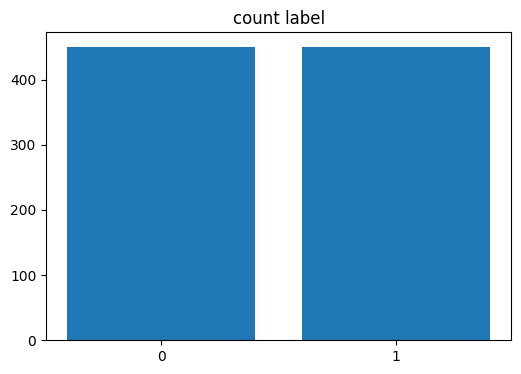

In [7]:
plt.figure(figsize=(6,4))
plt.bar(temp_df.label.value_counts().index, temp_df.label.value_counts().values)
plt.title('count label')
plt.xticks([0,1])
plt.show()

In [8]:
def clean_text(text):
    # memastikan dalam bentuk string
    text = str(text)

    # menghapus url
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)

    # Menghapus mentions (@username)
    text = re.sub(r'@\w+', '', text)

    # Menghapus hashtags (#hashtag)
    text = re.sub(r'#\w+', '', text)

    # Menghapus angka
    text = re.sub(r'\d+', '', text)
    
    # Menghapus karakter non-alphabetic (kecuali spasi)
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # menghapus punctuation
    text = text.translate(str.maketrans("","",string.punctuation))

    # menghilangkan new line \n
    text = re.sub("\n","", text)
    
    #menghapus double karakter
    text = re.sub(r'(.)\1+', r'\1', text)

    # Menghapus spasi tambahan
    text = text.strip()

    # huruf kecil semua
    text = text.lower()

    return text

In [9]:
stopword_pilkada = pd.read_csv(r'dataset\stopword_tweet_pilkada_DKI_2017.csv', header=None)
stopword_pilkada.columns = ['stopword']
stopword_pilkada.head()

,stopword
0,ada
1,adalah
2,adanya
3,adapun
4,agak


In [10]:
stop_words = set(stopwords.words('indonesian'))
additional_sw = set(stopword_pilkada['stopword'].values)

stop_words = stop_words.union(additional_sw)

def remove_stopwords(text):
    word_token = word_tokenize(text)
    filtered_sentences = [w for w in word_token if w not in stop_words]
    return ' '.join(filtered_sentences)

In [11]:
def preprocess_text(text):
    text = clean_text(text)
    text = remove_stopwords(text)
    return text

temp_df['text'] = temp_df['text'].apply(preprocess_text)
temp_df.head()

,label,text
0,0,akun kloning pendukung menyerang paslon opini ...
1,0,bicara kasihan yalap air matanya wkwkwkwk
2,0,sih nungu hasil qc tp nungu motif cuitan kayak...
3,0,kasian oh kasian peluru milyar rw mempan menan...
4,0,maf pendukung hayo dukung diputaran


In [12]:
df_train, df_test =  train_test_split(temp_df, test_size=0.3, random_state=42)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=42)

print(f"train size : {len(df_train)}")
print(f"val size : {len(df_val)}")
print(f"test size : {len(df_test)}")

train size : 630
val size : 135
test size : 135


In [13]:
PRETRAINED_MODEL ='indobenchmark/indobert-base-p2'

tokenizer = BertTokenizer.from_pretrained(PRETRAINED_MODEL)
vocab = tokenizer.get_vocab()
type(vocab)

dict

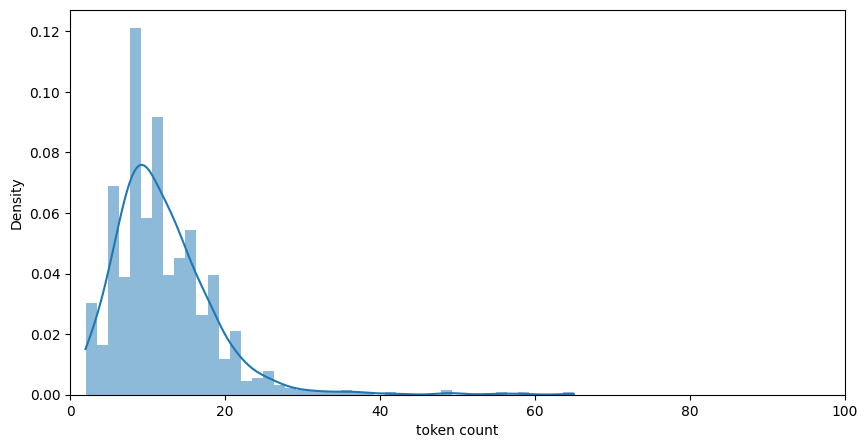

In [14]:
# cek distribusi untuk mengetahui panjang maksimal token

token_max = []

for txt in temp_df['text']:
    tokens = tokenizer.encode(txt)
    token_max.append(len(tokens))

plt.figure(figsize=(10,5))
sns.histplot(token_max, kde=True, stat='density', linewidth=0)
plt.xlim(0,100)
plt.xlabel("token count")
plt.show()

MAXLEN = 60

In [15]:
def encode_sentence(sent):
    return tokenizer.encode_plus(
        sent,
        add_special_tokens=True,
        padding='max_length',
        truncation='longest_first',
        max_length=MAXLEN,
        return_attention_mask=True,
        return_token_type_ids=True
    )

In [16]:
def map_example_to_dict(input_ids, attention_mask, token_type_ids, label):
    return{
        "input_ids" : input_ids,
        "attention_mask" : attention_mask,
        "token_type_ids" : token_type_ids,
    }, label

In [17]:
def encode_dataset(ds, limit = -1):
    input_ids_list = []
    attention_mask_list = []
    token_type_ids_list = []
    label_list = []

    for index, row in ds.iterrows():
        if limit > 0 and index >= limit:
            break

        input_ids, attention_mask, token_type_ids = \
        encode_sentence(row['text'])['input_ids'],\
        encode_sentence(row['text'])['attention_mask'], \
        encode_sentence(row['text'])['token_type_ids']

        label = row['label']

        input_ids_list.append(input_ids)
        attention_mask_list.append(attention_mask)
        token_type_ids_list.append(token_type_ids)
        label_list.append(label)
    
    return tf.data.Dataset.from_tensor_slices((
        input_ids_list,
        attention_mask_list,
        token_type_ids_list,
        label_list
    )).map(map_example_to_dict)

In [18]:
EPOCHS = 5
BATCH_SIZE = 32
LEARNING_RATE = 1e-5

train_data = encode_dataset(df_train).shuffle(42).batch(BATCH_SIZE)
val_data = encode_dataset(df_val).batch(BATCH_SIZE)
test_data = encode_dataset(df_test).batch(BATCH_SIZE)

In [19]:
model = TFBertForSequenceClassification.from_pretrained(PRETRAINED_MODEL, num_labels=2)
model.summary()

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  124441344 
                                                                 
 dropout_37 (Dropout)        multiple                  0         
                                                                 
 classifier (Dense)          multiple                  1538      
                                                                 
Total params: 124,442,882
Trainable params: 124,442,882
Non-trainable params: 0
_________________________________________________________________


In [20]:
optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metrics = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [21]:
history = model.fit(train_data, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=val_data)

Epoch 1/5


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).
The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.
The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).
The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.


20/20 [==============================] - ETA: 0s - loss: 0.6262 - accuracy: 0.6571

The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).
The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.


20/20 [==============================] - 33s 483ms/step - loss: 0.6262 - accuracy: 0.6571 - val_loss: 0.5442 - val_accuracy: 0.7407
Epoch 2/5
20/20 [==============================] - 6s 295ms/step - loss: 0.4356 - accuracy: 0.8127 - val_loss: 0.5702 - val_accuracy: 0.7333
Epoch 3/5
20/20 [==============================] - 6s 295ms/step - loss: 0.2979 - accuracy: 0.8905 - val_loss: 0.6548 - val_accuracy: 0.7407
Epoch 4/5
20/20 [==============================] - 6s 296ms/step - loss: 0.1721 - accuracy: 0.9413 - val_loss: 0.6929 - val_accuracy: 0.7630
Epoch 5/5
20/20 [==============================] - 6s 296ms/step - loss: 0.0832 - accuracy: 0.9794 - val_loss: 0.8094 - val_accuracy: 0.7704


In [22]:
model.evaluate(test_data)

5/5 [==============================] - 0s 90ms/step - loss: 0.5475 - accuracy: 0.8148


[0.5475360155105591, 0.8148148059844971]

In [23]:
y_pred = model.predict(test_data)
y_actual = np.concatenate([y for x, y in test_data], axis=0)

The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).
The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.


5/5 [==============================] - 4s 96ms/step


In [24]:
# accuracy_score(y_actual, np.argmax(y_pred[0], axis=1))
accuracy_score(y_actual, np.argmax(y_pred[0], axis=1))

0.8148148148148148

In [25]:
print(classification_report(y_actual, np.argmax(y_pred[0], axis=1)))

              precision    recall  f1-score   support

           0       0.83      0.82      0.82        71
           1       0.80      0.81      0.81        64

    accuracy                           0.81       135
   macro avg       0.81      0.81      0.81       135
weighted avg       0.82      0.81      0.81       135



<Axes: >

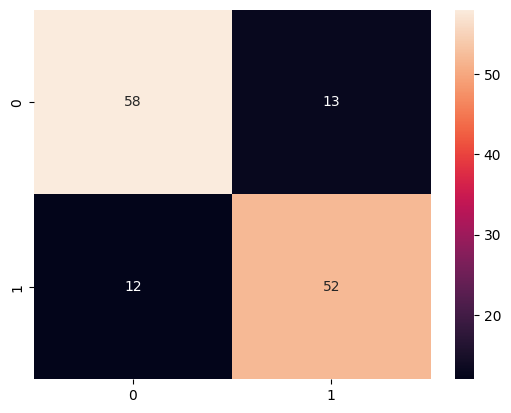

In [26]:
cm = confusion_matrix(y_actual, np.argmax(y_pred[0], axis = 1))
sns.heatmap(cm, annot=True, fmt='d')